In [23]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import numpy as np
from scipy.optimize import curve_fit
import jax
import jax.numpy as jnp
import tqdm
from joblib import Parallel, delayed
from itertools import product
from scipy.optimize import OptimizeWarning
import warnings

In [24]:
import sys
sys.path.insert(0, "/home/tfioratti/git/stockora/")
from stockora.shadow_clone import parallelize

In [8]:
def g_linspace(start, end, n_points):
    xi = np.linspace(-1, 1, n_points)
    return (start + end)/2 + (end - start)/2 * xi**3
def exp_decay(t, A, tau, C):
    return A * np.exp(-t / tau) + C
def cosine_sim (h0,h1):
    dot_product = jnp.dot(h0, h1)
    norm_h0 = jnp.linalg.norm(h0)
    norm_h1 = jnp.linalg.norm(h1)
    return dot_product / (norm_h0 * norm_h1)
def calculate_norm(h_t):
    return jnp.sqrt(jnp.mean(h_t ** 2))

In [9]:
import jax
import jax.numpy as jnp
from jax.lax import scan
from jax import random, vmap
from functools import partial
import pdb

def define_pars(key, hidden_size,  bias, vol, normalize=False):
    k1, k2, k3, k4, k5, k6, k7, k8 = random.split(key,8)

    scale_f = vol / jnp.sqrt(hidden_size) if normalize else vol
    b_scale = bias

    W_i = jax.random.normal(k1, (hidden_size, hidden_size)) * scale_f
    b_i = jax.random.normal(k5, (hidden_size,)) * b_scale
    W_f = jax.random.normal(k2, (hidden_size, hidden_size)) * scale_f
    b_f = jax.random.normal(k6, (hidden_size,)) * b_scale
    W_c = jax.random.normal(k3, (hidden_size, hidden_size)) * scale_f
    b_c = jax.random.normal(k7, (hidden_size,)) * b_scale
    W_o = jax.random.normal(k4, (hidden_size, hidden_size)) * scale_f
    b_o = jax.random.normal(k8, (hidden_size,)) * b_scale

    return W_i, b_i, W_f, b_f, W_c, b_c, W_o, b_o

def single_lstm_cell(key, hidden_size, bias, num_steps, vol, normalize=False):
    from jax.nn import sigmoid, tanh
    pars = define_pars(key, hidden_size,bias, vol, normalize)
    def f_scan(carry, _):
        h, c, W_i, b_i, W_f, b_f, W_c, b_c, W_o, b_o = carry
        z = h  # Usa solo h per l'evoluzione
        i = sigmoid(jnp.dot(z, W_i) + b_i)
        f = sigmoid(jnp.dot(z, W_f) + b_f)
        o = sigmoid(jnp.dot(z, W_o) + b_o)
        c_hat = tanh(jnp.dot(z, W_c) + b_c)
        
        c = f * c + i * c_hat
        h = o * tanh(c)
        return (h, c, W_i, b_i, W_f, b_f, W_c, b_c, W_o, b_o), h

    h0 = random.normal(key)*jnp.ones(hidden_size)
    key, subkey = random.split(key)
    rand_vec = random.normal(subkey, (hidden_size,))
    w = rand_vec - jnp.dot(h0,rand_vec)*h0/jnp.linalg.norm(h0)**2
    h1 = h0 + w*jnp.sqrt(3.0)*jnp.linalg.norm(h0)/(jnp.linalg.norm(w)+ 1e-6)
    c0 = jnp.zeros(hidden_size)
    initial_state0 = (h0, c0) + pars  
    initial_state1 = (h1, c0) + pars  
    xs = jnp.zeros((num_steps,))  
    _, outputs0 = scan(f_scan, initial_state0, xs)
    _, outputs1 = scan(f_scan, initial_state1, xs)
    outputs0 = jnp.concatenate((h0[None, :], outputs0[:-1]), axis=0)
    outputs1 = jnp.concatenate((h1[None, :], outputs1[:-1]), axis=0)
    return outputs0, outputs1

def LSTMCell_test(keys, hidden_size, bias, num_steps, vol, normalize=False):
    cell_fixed = partial(
        single_lstm_cell,
        hidden_size = hidden_size,
        bias = bias,
        num_steps = num_steps, 
        vol=vol, 
        normalize=normalize
    )
    batched_cell = vmap(cell_fixed)
    return batched_cell(keys)

In [10]:
def compute_tau_c(params, seeds, hidden_size, num_steps):
    b = params['b']
    g = params['g_factor']
    h0,h1 = LSTMCell_test(seeds, hidden_size, b, num_steps, g, normalize=False)
    c_all_seeds = jnp.array([
    jnp.array([cosine_sim(h0_t, h1_t) for h0_t, h1_t in zip(h0_seed, h1_seed)])
    for h0_seed, h1_seed in zip(h0, h1)
    ])
    c_mean = jnp.mean(c_all_seeds, axis=0)
    fixed_points = jnp.mean(c_mean[-10:])
    #print(fixed_points) analisi sotto soglia
    eps = 1e-1
    if(fixed_points < 1 - eps):
        return num_steps
    cosine_centered = jnp.abs(fixed_points - c_mean)
    #plt.figure()
    #plt.plot(cosine_centered[10:])
    ##plt.legend([f"b={b}, g={g*jnp.sqrt(hidden_size)/2}"])
    #plt.xlabel("Times Step")
    #plt.ylabel("Centered Cosine Similarity")
    #plt.title("Cosine Centered Over Steps")
    #plt.show()
    cosine_centered_np = np.array(cosine_centered[10:])
    #pdb.set_trace()
    x_data = np.arange(num_steps-10)
    popt, _ = curve_fit(exp_decay, x_data, cosine_centered_np)
    tau = float(min(popt[1], num_steps))

    return tau

In [11]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import random

key = jax.random.PRNGKey(1)
hidden_size = 1000
g_factors = jnp.linspace(0.95, 1.5, 30) #proviamo con 100 e 20 bias  
g_critico = 2 / jnp.sqrt(hidden_size)
g = g_factors * g_critico  
num_steps = 2000
num_seeds = 100 
bias_values = 0.01 * jnp.linspace(1, 100, 20)  

seeds = random.split(key, num_seeds)

tau = np.zeros((len(bias_values), len(g_factors)))

#h0, h1 = LSTMCell_test(seeds,hidden_size, b, num_steps , arr, normalize=False)
#print(h0.shape) #seed x num steps x hidden size


In [ ]:
for b_idx, b in enumerate(bias_values):
    for g_idx, vol in enumerate(g):
        tau[b_idx, g_idx] = compute_tau_c(b, vol, seeds, hidden_size, num_steps)
        print(f"tau for b={b} and g={g_factors[g_idx]}: {float(tau[b_idx, g_idx])}")

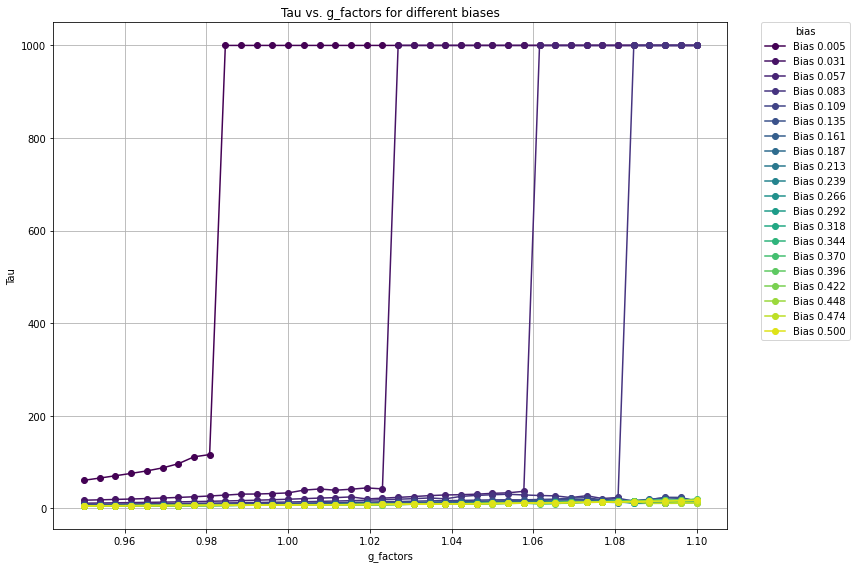

In [35]:
cmap = plt.get_cmap('viridis')  
colors = [cmap(i / len(bias_values) )for i in range(len(bias_values))]  

plt.figure(figsize=(12, 8))

for i in range(len(bias_values)):
    plt.plot(g_factors, tau[i, :], label=f'Bias {bias_values[i]:.3f}', color=colors[i], marker='o')


plt.title('Tau vs. g_factors for different biases')
plt.xlabel('g_factors')
plt.ylabel('Tau')
plt.legend(title='bias', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True)

plt.tight_layout()
plt.savefig('Tau_vs_g_factors.png') 
plt.show()


In [12]:
jobs = [{'b': float(b), 'g_factor': float(g_factor)} for b in bias_values for g_factor in g]
results = parallelize(
    exec_func=compute_tau_c,
    jobs=jobs,
    single_arg = True,
    exec_kwargs=dict(seeds = seeds, hidden_size=hidden_size, num_steps=num_steps),
    mode="slurm",
    wait_for_graph_execution=False,
    root_dir=f"/mnt/live/user/tfioratti/parallelize_test",
)

Graph tfioratti__parallelize_test posted. Follow the execution using the [grid view](https://srv006545.fr.cfm.fr:56006/graph/index.html#/manage/tfioratti__parallelize_test) or the [graph view](https://srv006545.fr.cfm.fr:56006/graph/index.html#/display/tfioratti__parallelize_test)

In [13]:
import json
from pathlib import Path

results_dir = Path("/mnt/live/user/tfioratti/parallelize_test/execution_results")

data_dict = {}

for result_file in results_dir.glob("*.json"):  
    with open(result_file, 'r') as file:
        data = json.load(file)
    tau_value = data  
    file_key = result_file.stem
    data_dict[file_key] = tau_value


In [14]:
full_range_keys = [str(i) for i in range(600)]

tau_values_list = [data_dict.get(key, np.nan) for key in full_range_keys]

tau = np.array(tau_values_list).reshape(20, 30)


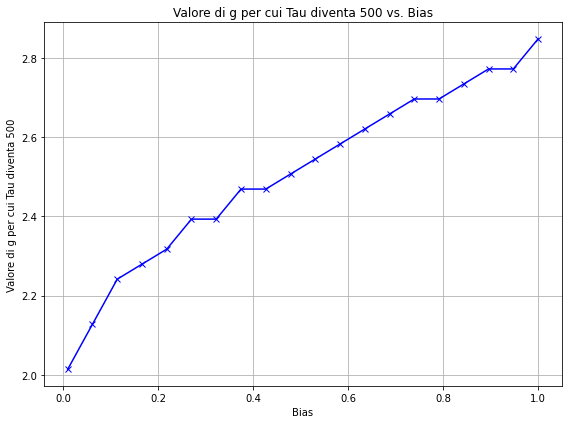

In [21]:
g_for_tau_500 = []

for i in range(len(bias_values)):
    try:
        index = np.where(tau[i, :] >= 1000)[0][0]
        g_for_tau_500.append(g_factors[index])
    except IndexError:
        g_for_tau_500.append(np.nan) # oppure None

plt.figure(figsize=(8, 6))
plt.plot(bias_values, 2*np.array(g_for_tau_500), marker='x', linestyle='-', color='b')
plt.title('Valore di g per cui Tau diventa 500 vs. Bias')
plt.xlabel('Bias')
plt.ylabel('Valore di g per cui Tau diventa 500')
plt.grid(True)

plt.tight_layout()
plt.show()